In [14]:
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
np.random.seed(42)

import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [15]:
import keras
#from keras.utils import np_utils
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D,AveragePooling2D, ZeroPadding2D
from keras.layers import Input, Add
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [16]:
IMG_CHANNELS = 3
IMG_ROWS = 128
IMG_COLS = 128

#CONSTANT
BATCH_SIZE = 16
NB_EPOCH = 15
NB_CLASSES = 2
VERBOSE = 1
VALIDATION_SPLIT = 0.15
OPTIM = Adam(lr=0.005)  # Other optimizers are SGD, Adam, Adagrad

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip  '/content/gdrive/My Drive/Colab_Dataset/Dataset2.zip'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/Colab_Dataset/Dataset2.zip
replace COVID/Covid (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COV

In [18]:
image_name = []
image_label = []

for file in os.listdir('COVID'):
    filename, fileextension = os.path.splitext(file)     
    if(fileextension == '.png'):
        file_path = 'COVID' + '/' + file
        image_name.append(file_path)
        image_label.append(1)
        
        
for file in os.listdir('non-COVID'):
    filename, fileextension = os.path.splitext(file)
    if(fileextension == '.png'):
        file_path = 'non-COVID' + '/' + file
        image_name.append(file_path)
        image_label.append(0)
        

In [19]:
WIDTH = 128
HEIGHT = 128
def process_image():
    #Return two array. One of resized images and other of array of labels
    x = []  # array of images
    y = []  # array of labels
   
    
    for i in range(0,len(image_name)):
        #Read and resize image
        full_size_image = cv2.imread(image_name[i])
        x.append(cv2.resize(full_size_image,(WIDTH, HEIGHT),interpolation=cv2.INTER_CUBIC));
        # Labels
        y.append(image_label[i])
        
    return x,y

x,y = process_image()

In [20]:
x = np.asarray(x)
y = np.asarray(y)
print('Shape of x: ',x.shape, '  Shape of y: ', y.shape)
print('Dimension of x: ', x.ndim, '  Dimension of y: ', y.ndim)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
print('Shape of X_train: ',X_train.shape, '  Shape of y_train: ', y_train.shape)
print('Shape of X_test: ',X_test.shape, '  Shape of y_test: ', y_test.shape)


Shape of x:  (2481, 128, 128, 3)   Shape of y:  (2481,)
Dimension of x:  4   Dimension of y:  1
Shape of X_train:  (1984, 128, 128, 3)   Shape of y_train:  (1984,)
Shape of X_test:  (497, 128, 128, 3)   Shape of y_test:  (497,)


In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    #zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode="nearest"
)


test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0)


train_generator = train_datagen.flow(X_train,y_train, batch_size = BATCH_SIZE)


test_generator = test_datagen.flow(X_test,y_test, batch_size = BATCH_SIZE)


In [22]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096, activation='relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000, activation='relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(1e-5), loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         8

In [23]:
model_history = model.fit_generator(train_generator,epochs=100 ,validation_data=test_generator)
                              

score = model.evaluate_generator(test_generator)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Epoch 1/100
124/124 [==============================] - 5s 38ms/step - loss: 0.6904 - accuracy: 0.5262 - val_loss: 0.6828 - val_accuracy: 0.7344
Epoch 2/100
124/124 [==============================] - 4s 36ms/step - loss: 0.6665 - accuracy: 0.5882 - val_loss: 0.6098 - val_accuracy: 0.7243
Epoch 3/100
124/124 [==============================] - 4s 36ms/step - loss: 0.5989 - accuracy: 0.6825 - val_loss: 0.5821 - val_accuracy: 0.6640
Epoch 4/100
124/124 [==============================] - 4s 36ms/step - loss: 0.5506 - accuracy: 0.7308 - val_loss: 0.5294 - val_accuracy: 0.7344
Epoch 5/100
124/124 [==============================] - 5s 36ms/step - loss: 0.5099 - accuracy: 0.7540 - val_loss: 0.5382 - val_accuracy: 0.7223
Epoch 6/100
124/124 [==============================] - 4s 36ms/step - loss: 0.4973 - accuracy: 0.7566 - val_loss: 0.5282 - val_accuracy: 0.7183
Epoch 7/100
124/124 [==============================] - 5s 36ms/step - loss: 0.4686 - accuracy: 0.7792 - val_loss: 0.4944 - val_accuracy:

Train Score:  3.896308498951839e-06
Train Accuracy:  1.0


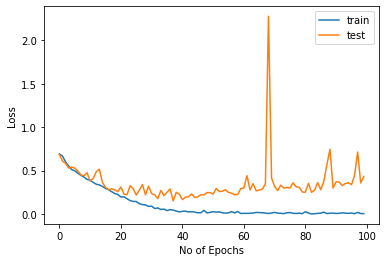

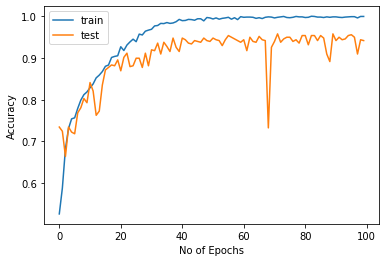

In [24]:
print('Train Score: ',model.evaluate_generator(train_generator)[0])
print('Train Accuracy: ',model.evaluate_generator(train_generator)[1])

plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# learning curves of model accuracy
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
model.save('Saved Models/CNN2.h5')